# 모듈 설치

In [1]:
!pip install torch torchvision numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# 데이터셋

In [3]:
#데이터셋 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR10 데이터셋을 다운로드 & dataloader 생성
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 43068157.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


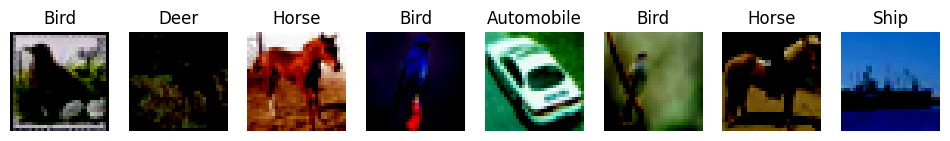

In [4]:
# 레이블 숫자를 클래스 이름으로 매핑하는 딕셔너리
class_names = [
    'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
    'Dog', 'Frog', 'Horse', 'Ship', 'Truck'
]

def show_images(images, labels):
    npimg = images.numpy()  # 이미지를 numpy 배열로 변환
    fig, axes = plt.subplots(1, 8, figsize=(12, 12))

    # 이미지 출력
    for i in range(8):
        ax = axes[i]
        img = np.transpose(npimg[i], (1, 2, 0))  # 채널 차원을 마지막으로 이동
        ax.imshow(img)  # 이미지를 표시
        ax.set_title(f'{class_names[labels[i].item()]}')
        ax.axis('off')
    plt.show()

# 이미지 배치를 불러옴
dataiter = iter(dataloader)
images, labels = next(dataiter)

show_images(images, labels)

# 생성기 판별기 클래스

In [41]:
# Generator 정의
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # CIFAR-10 이미지는 [-1, 1] 범위로 정규화됨
        )

    def forward(self, x):
        return self.model(x).view(-1, 3, 32, 32)  # 이미지 차원으로 변환

# Discriminator 정의
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()  # 출력이 0과 1 사이의 확률로 변환됨
        )

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # 1D 벡터로 변환
        return self.model(x)

# 손실함수, 하이퍼파라미터

In [42]:
# Latent dimension과 이미지 차원 정의
latent_dim = 100
img_shape = 32 * 32 * 3  # CIFAR-10은 32x32 픽셀에 3채널

generator = Generator(input_dim=latent_dim, output_dim=img_shape)
discriminator = Discriminator(input_dim=img_shape)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss = nn.BCELoss()

#학습

In [43]:
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)

if not os.path.exists("images"):
    os.mkdir("images")

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짠지 가짠지에 대한 레이블 생성
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        # 진짜 이미지 (데이터셋에서 불러온거)
        real_imgs = imgs.view(imgs.size(0), -1).to(device)

        # 생성기 학습
        optimizer_G.zero_grad()

        # 랜덤 노이즈로부터 이미지 생성
        z = torch.randn((imgs.size(0), latent_dim)).to(device)
        gen_imgs = generator(z)

        # 생성된 이미지를 판별자에 넣어서 결과 확인
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()


        # 판별기 학습
        optimizer_D.zero_grad()

        # 진짜 이미지 판별
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, loss G: {g_loss.item()}")

    # 중간 단계 확인을 위해 생성된 이미지 저장
    if epoch % 10 == 0:
        gen_imgs = gen_imgs.view(gen_imgs.size(0), 3, 32, 32)
        save_image(gen_imgs.data[:25], f"images/{epoch}.png", nrow=5, normalize=True)


Epoch [0/50] Batch 0/782                   Loss D: 0.6931941509246826, loss G: 0.7134149074554443
Epoch [0/50] Batch 400/782                   Loss D: 0.1318296492099762, loss G: 3.9086694717407227
Epoch [1/50] Batch 0/782                   Loss D: 0.037725213915109634, loss G: 6.096510410308838
Epoch [1/50] Batch 400/782                   Loss D: 0.03843708708882332, loss G: 4.419241905212402
Epoch [2/50] Batch 0/782                   Loss D: 0.16298702359199524, loss G: 2.287184715270996
Epoch [2/50] Batch 400/782                   Loss D: 0.28003525733947754, loss G: 6.17697811126709
Epoch [3/50] Batch 0/782                   Loss D: 0.04999164119362831, loss G: 2.474785327911377
Epoch [3/50] Batch 400/782                   Loss D: 0.14692053198814392, loss G: 2.2544145584106445
Epoch [4/50] Batch 0/782                   Loss D: 0.11361251771450043, loss G: 2.4700303077697754
Epoch [4/50] Batch 400/782                   Loss D: 0.06837202608585358, loss G: 2.865020990371704
Epoch [5

# 결과

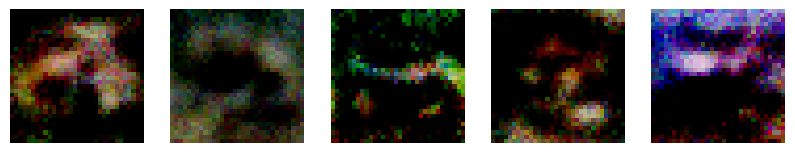

In [44]:
def show_generated_imgs(generator, latent_dim, num_images=5):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim).to(device)
        gen_imgs = generator(z)
        gen_imgs = gen_imgs.view(num_images, 3, 32, 32)  #CIFAR-10 이미지 크기로 수정

        gen_imgs = gen_imgs.detach().cpu().numpy()
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i in range(num_images):
            axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)))
            axes[i].axis('off')
        plt.show()

show_generated_imgs(generator, latent_dim)

# 생성기 판별기 레이어 수정

In [49]:
latent_dim = 100
img_shape = (3, 32, 32)

#수정된 생성기
class Generator2(nn.Module):
    def __init__(self):
        super(Generator2, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1, bias=False),
            nn.Tanh()  #CIFAR-10은 -1에서 1사이의 값으로 정규화
        )

    def forward(self, x):
        return self.model(x)

# Discriminator model
class Discriminator2(nn.Module):
    def __init__(self):
        super(Discriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)

#모델 초기화, 하이퍼 파라미터

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator2 = Generator2().to(device)
discriminator2 = Discriminator2().to(device)

lr = 0.0002
b1 = 0.5
b2 = 0.999

optimizer_G2 = optim.Adam(generator2.parameters(), lr=lr, betas=(b1, b2))
optimizer_D2 = optim.Adam(discriminator2.parameters(), lr=lr, betas=(b1, b2))

adversarial_loss2 = nn.BCELoss()

#훈련

In [51]:
num_epochs = 50
batch_size = 64

if not os.path.exists("images2"):
    os.mkdir("images2")

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        valid = torch.ones((imgs.size(0), 1), requires_grad=False).to(device)
        fake = torch.zeros((imgs.size(0), 1), requires_grad=False).to(device)

        real_imgs = imgs.to(device)

        optimizer_G2.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim, 1, 1).to(device)
        gen_imgs = generator2(z)
        g_loss = adversarial_loss2(discriminator2(gen_imgs), valid)
        g_loss.backward()
        optimizer_G2.step()

        optimizer_D2.zero_grad()
        real_loss = adversarial_loss2(discriminator2(real_imgs), valid)
        fake_loss = adversarial_loss2(discriminator2(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D2.step()

        if i % 400 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Batch {i}/{len(dataloader)} \
                  Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")

    if epoch % 10 == 0:
        gen_imgs = gen_imgs.detach().cpu()
        save_image(gen_imgs.data[:25], f"images2/{epoch}.png", nrow=5, normalize=True)

Epoch [0/50] Batch 0/782                   Loss D: 0.742121696472168, Loss G: 0.957785964012146
Epoch [0/50] Batch 400/782                   Loss D: 0.08411622047424316, Loss G: 2.9263229370117188
Epoch [1/50] Batch 0/782                   Loss D: 0.25155407190322876, Loss G: 2.1391379833221436
Epoch [1/50] Batch 400/782                   Loss D: 0.10713004320859909, Loss G: 3.077552318572998
Epoch [2/50] Batch 0/782                   Loss D: 0.7575287818908691, Loss G: 0.6012631058692932
Epoch [2/50] Batch 400/782                   Loss D: 0.09381066262722015, Loss G: 3.0503931045532227
Epoch [3/50] Batch 0/782                   Loss D: 0.14607121050357819, Loss G: 2.3383049964904785
Epoch [3/50] Batch 400/782                   Loss D: 0.30695289373397827, Loss G: 1.203860878944397
Epoch [4/50] Batch 0/782                   Loss D: 0.6312386989593506, Loss G: 3.6606807708740234
Epoch [4/50] Batch 400/782                   Loss D: 0.27820032835006714, Loss G: 2.954540729522705
Epoch [5

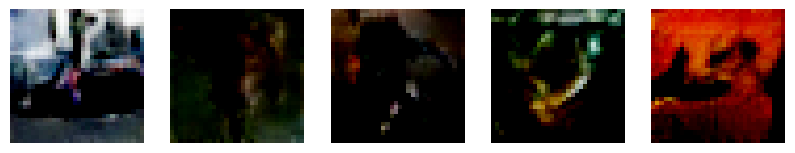

In [54]:
def show_generated_imgs(generator, latent_dim, num_images=5):
    generator.eval()
    with torch.no_grad():
        #Latent 벡터를 4D 텐서로 변환해야함
        z = torch.randn(num_images, latent_dim, 1, 1).to(device)
        gen_imgs = generator(z)
        gen_imgs = gen_imgs.detach().cpu().numpy()

        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i in range(num_images):
            axes[i].imshow(np.transpose(gen_imgs[i], (1, 2, 0)))
            axes[i].axis('off')
        plt.show()

show_generated_imgs(generator2, latent_dim)